In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path('Images/')

In [29]:
def mysplit(s):
    head = s.rstrip('0123456789')
    tail = s[len(head):]
    return head
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x:((os.path.split(x)[1]).split(".")[0]), filepaths))
print(labels)
print(filepaths)
truelabels = []
for x in labels:
    truelabels.append(mysplit(x))

['almond', 'almond1', 'almond4', 'almond5', 'almond6', 'dairy1', 'dairy3', 'dairy5', 'dairy6', 'grapes', 'grapes1', 'grapes2', 'grapes3', 'grapes4', 'grapes5', 'grapes6', 'lettuce', 'lettuce2', 'lettuce3', 'lettuce4', 'rice', 'rice2', 'rice3', 'rice4', 'rice5', 'rice6', 'strawberry', 'strawberry1', 'strawberry2', 'strawberry3', 'strawberry5', 'strawberry6']
[WindowsPath('Images/almond.jpg'), WindowsPath('Images/almond1.jpg'), WindowsPath('Images/almond4.jpg'), WindowsPath('Images/almond5.jpg'), WindowsPath('Images/almond6.jpg'), WindowsPath('Images/dairy1.jpg'), WindowsPath('Images/dairy3.jpg'), WindowsPath('Images/dairy5.jpg'), WindowsPath('Images/dairy6.jpg'), WindowsPath('Images/grapes.jpg'), WindowsPath('Images/grapes1.jpg'), WindowsPath('Images/grapes2.jpg'), WindowsPath('Images/grapes3.jpg'), WindowsPath('Images/grapes4.jpg'), WindowsPath('Images/grapes5.jpg'), WindowsPath('Images/grapes6.jpg'), WindowsPath('Images/lettuce.jpg'), WindowsPath('Images/lettuce2.jpg'), WindowsPath('I

In [33]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(truelabels, name='Label')
images = pd.concat([filepaths, labels], axis=1)


In [43]:

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(4, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [44]:
image_df

,Filepath,Label
0,Images\lettuce3.jpg,lettuce
1,Images\rice5.jpg,rice
2,Images\almond.jpg,almond
3,Images\lettuce.jpg,lettuce
4,Images\strawberry2.jpg,strawberry
5,Images\rice2.jpg,rice
6,Images\grapes1.jpg,grapes
7,Images\dairy6.jpg,dairy
8,Images\almond6.jpg,almond
9,Images\rice.jpg,rice


In [45]:
image_df['Label'].value_counts()


Label
lettuce       4
rice          4
almond        4
strawberry    4
grapes        4
dairy         4
Name: count, dtype: int64

In [46]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [47]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [48]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 13 validated image filenames belonging to 6 classes.
Found 3 validated image filenames belonging to 6 classes.
Found 8 validated image filenames belonging to 6 classes.


In [49]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False




9406464/9406464 [==============================] - 0s 0us/step


In [52]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [53]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 2.1203 - accuracy: 0.2308 - val_loss: 1.7155 - val_accuracy: 0.3333
Epoch 2/100
1/1 [==============================] - 1s 593ms/step - loss: 1.2308 - accuracy: 0.6923 - val_loss: 1.8316 - val_accuracy: 0.3333
Epoch 3/100
1/1 [==============================] - 1s 594ms/step - loss: 0.7374 - accuracy: 1.0000 - val_loss: 1.9289 - val_accuracy: 0.3333
Epoch 4/100
1/1 [==============================] - 1s 642ms/step - loss: 0.4497 - accuracy: 1.0000 - val_loss: 2.0051 - val_accuracy: 0.3333


In [54]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


Test Accuracy: 50.00%


In [55]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)


1/1 [==============================] - 2s 2s/step


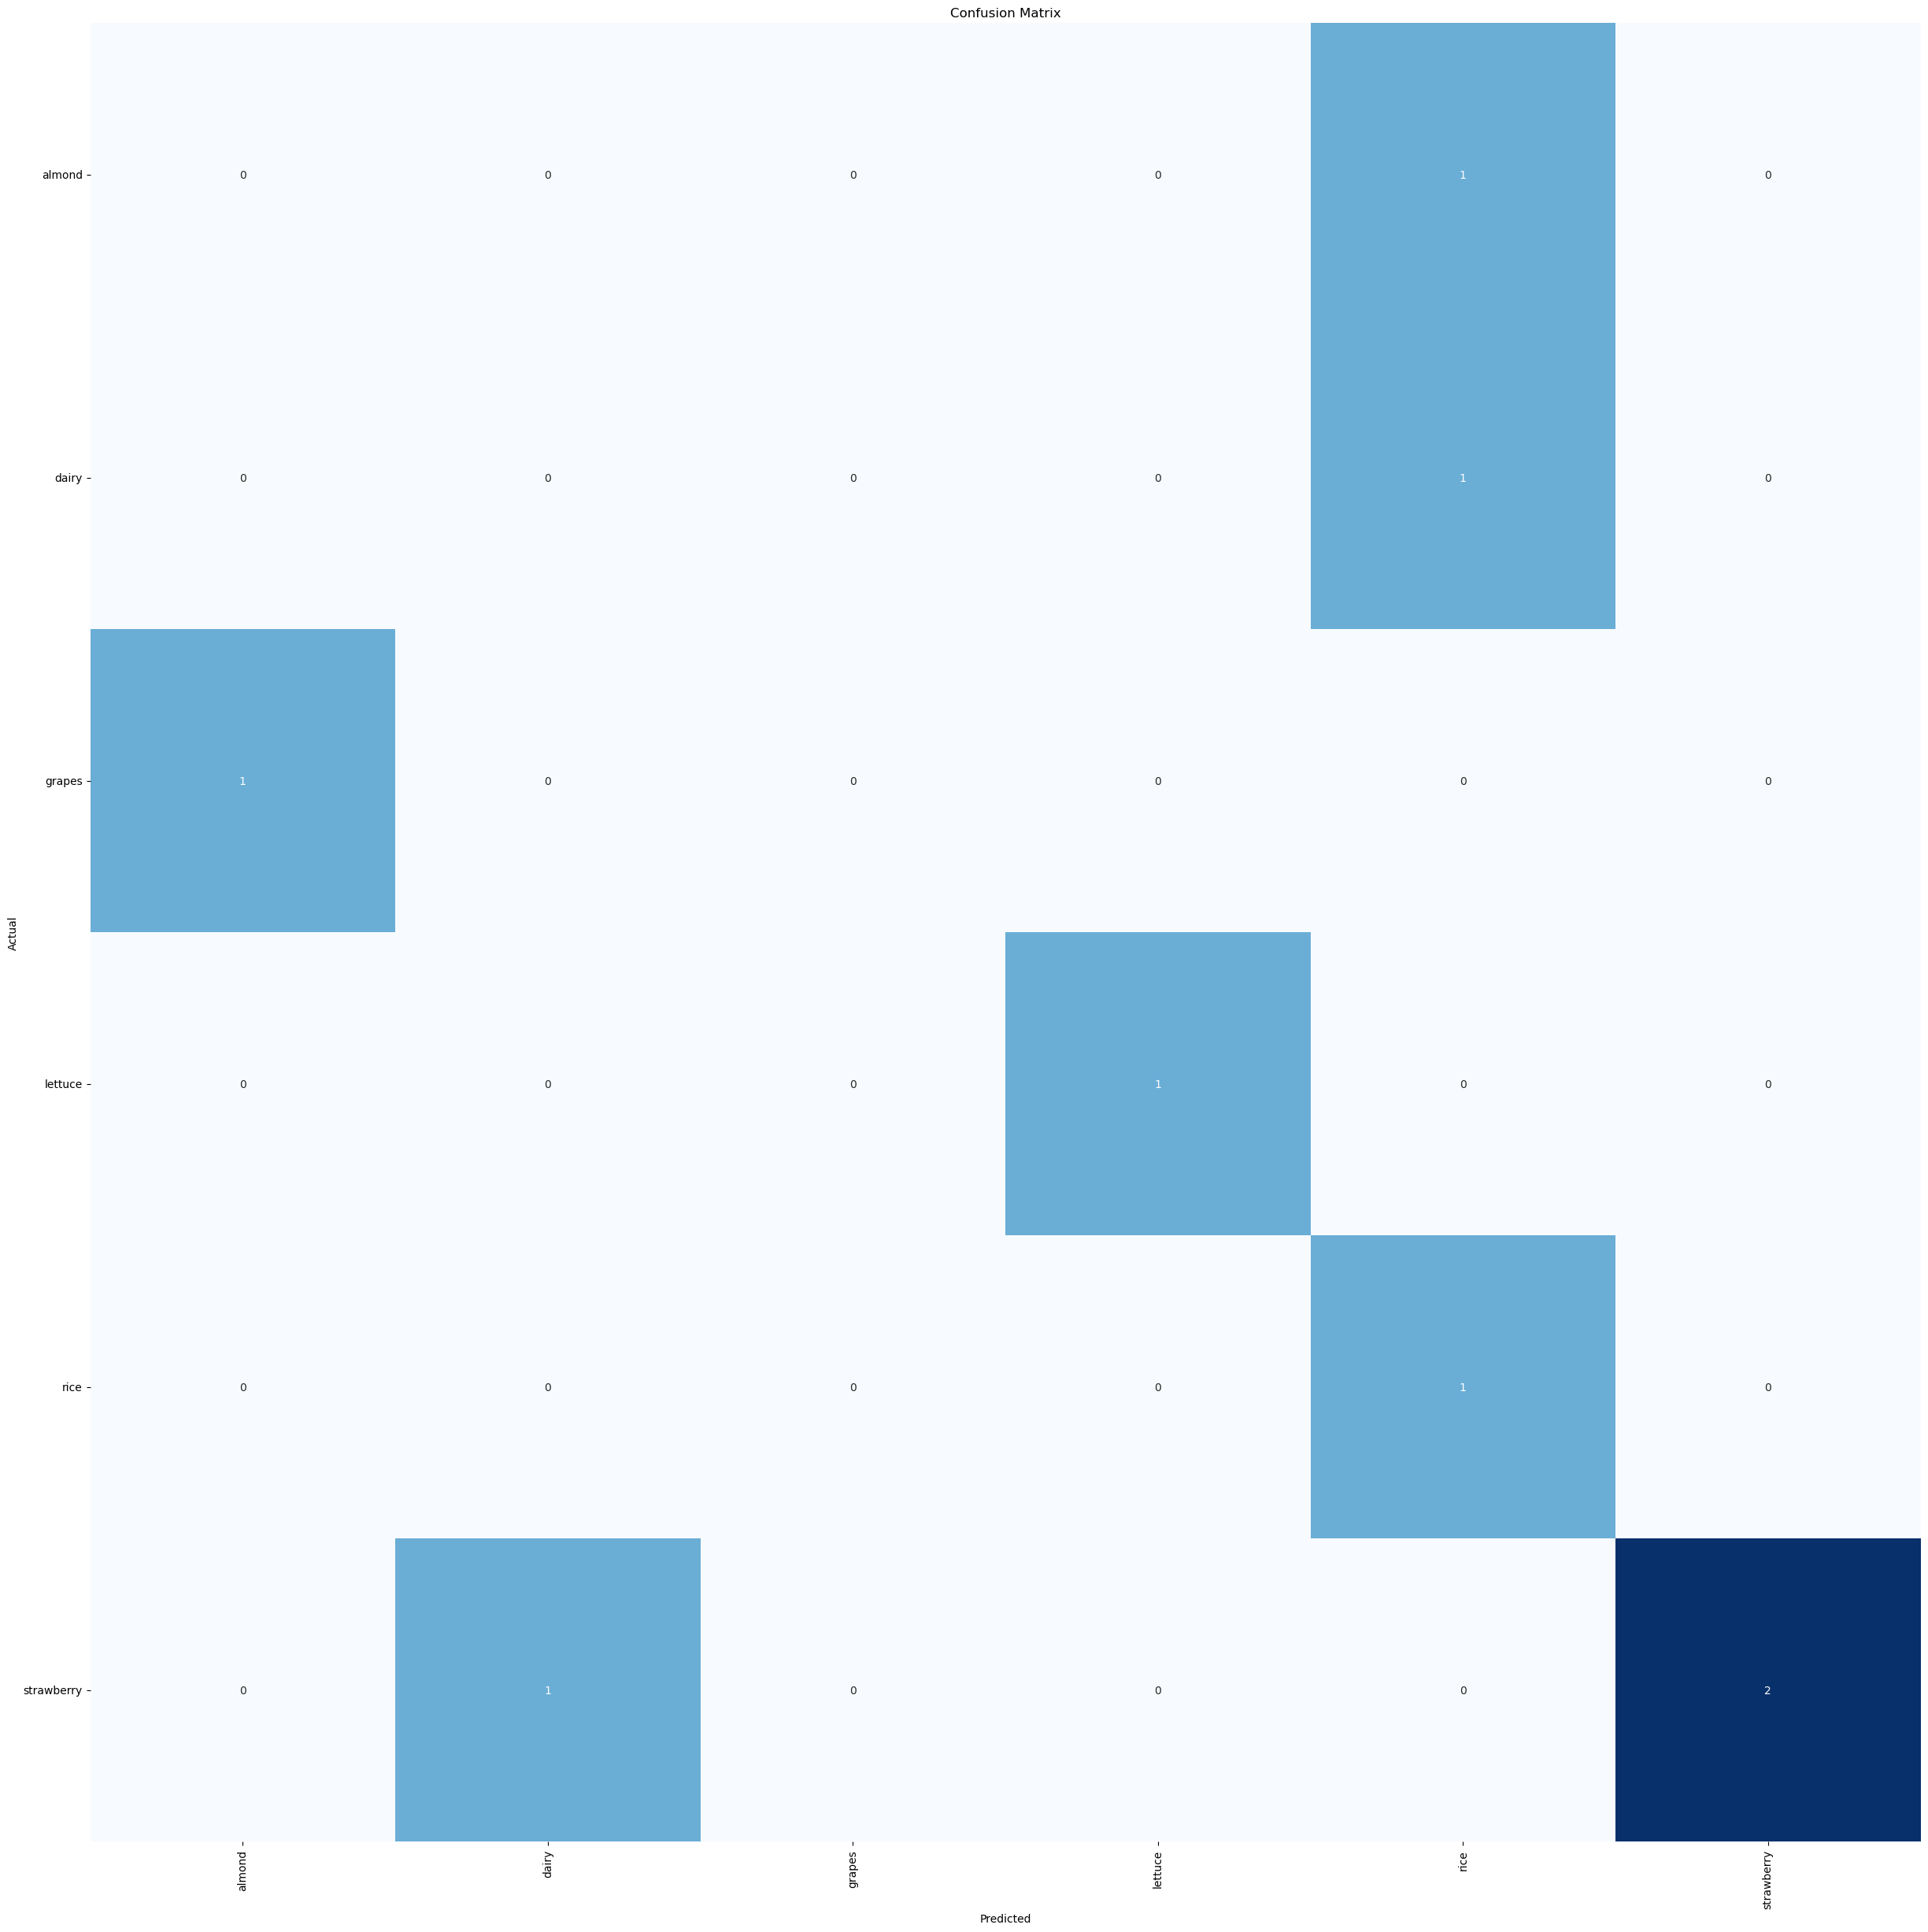

In [57]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(6) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(6) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [58]:
print("Classification Report:\n----------------------\n", clr)


Classification Report:
----------------------
               precision    recall  f1-score   support

      almond       0.00      0.00      0.00         1
       dairy       0.00      0.00      0.00         1
      grapes       0.00      0.00      0.00         1
     lettuce       1.00      1.00      1.00         1
        rice       0.33      1.00      0.50         1
  strawberry       1.00      0.67      0.80         3

    accuracy                           0.50         8
   macro avg       0.39      0.44      0.38         8
weighted avg       0.54      0.50      0.49         8



In [59]:
print(predictions)

[4 5 3 4 0 1 4 5]
